# Feature Show

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

Could not find GLIMDA.


## ODE models

### Basic models

In [2]:
m = Model()
m.add_parameters({"v0": 1, "k1p": 0.5, "k1m": 1, "k2": 0.1})
m.add_compounds(["X", "Y"])
m.add_reaction_from_ratelaw(rate_name="v0", ratelaw=rl.Constant(product="X", k="v0"))
m.add_reaction_from_ratelaw(
    rate_name="v1",
    ratelaw=rl.ReversibleMassAction(
        substrates=["X"], products=["Y"], k_fwd="k1p", k_bwd="k1m"
    ),
)
m.add_reaction_from_ratelaw(
    rate_name="v2", ratelaw=rl.MassAction(substrates=["Y"], products=[], k_fwd="k2")
)

#### Time simulations

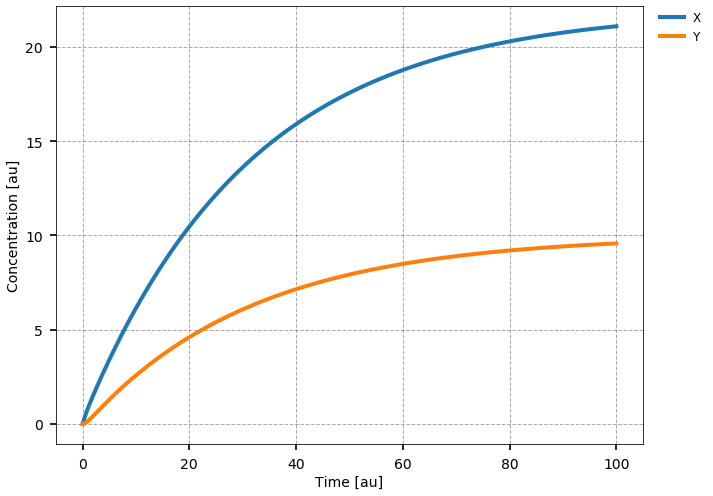

In [3]:
s = Simulator(m)
s.initialise({"X": 0, "Y": 0})
t, y = s.simulate(100)
fig, ax = s.plot(xlabel="Time [au]", ylabel="Concentration [au]")
plt.show()

#### Steady state functions

In [4]:
t_ss, y_ss = s.simulate_to_steady_state()
y_ss

array([[22.00000002, 10.00000001]])

#### Parameters scans

In [5]:
# Scan steady state concentrations depending on parameter values

s.parameter_scan(parameter_name="v0", parameter_values=np.linspace(0, 10, 11))

X      Y
0.0     0.0    0.0
1.0    22.0   10.0
2.0    44.0   20.0
3.0    66.0   30.0
4.0    88.0   40.0
5.0   110.0   50.0
6.0   132.0   60.0
7.0   154.0   70.0
8.0   176.0   80.0
9.0   198.0   90.0
10.0  220.0  100.0

### Time-dependent external conditions

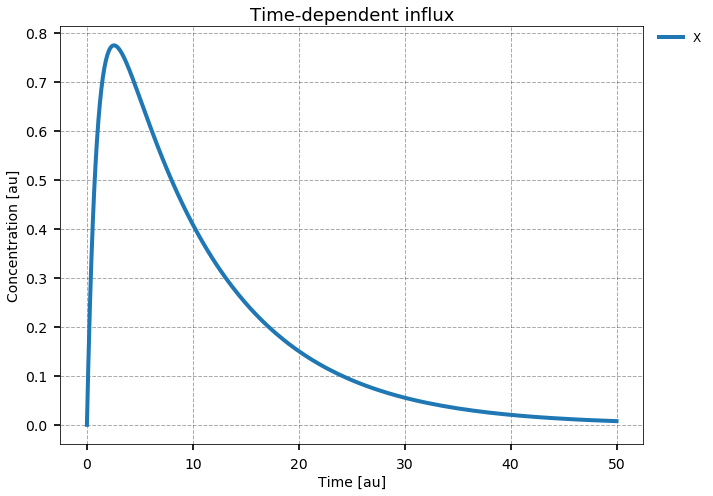

In [6]:
def time_dependent_influx(time, k):
    "Time dependent influx"
    return np.exp(-k * time)


p = {"l": 1, "k": 0.1}

m = Model(p)
m.add_compounds(["X"])
m.add_reaction(
    rate_name="v0",
    function=time_dependent_influx,
    stoichiometry={"X": 1},
    modifiers=["time"],
    parameters=["l"],
)
m.add_reaction_from_ratelaw(
    rate_name="v1", ratelaw=rl.MassAction(substrates=["X"], products=[], k_fwd="k"),
)

s = Simulator(m)
s.initialise({"X": 0})
t, y = s.simulate(50)
fig, ax = s.plot(
    xlabel="Time [au]", ylabel="Concentration [au]", title="Time-dependent influx",
)
plt.show()

### Algebraic modules

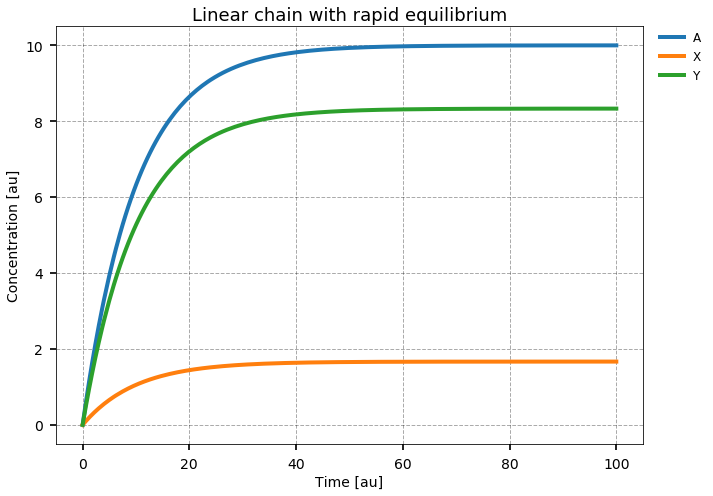

In [7]:
def rapid_equilibrium(substrate, k_eq):
    "Rapid equilibrium approximation"
    x = substrate / (1 + k_eq)
    y = substrate * k_eq / (1 + k_eq)
    return x, y


p = {"k0": 1, "k2": 0.1, "K": 5}
m = Model(p)
m.add_compounds(["A"])

m.add_algebraic_module(
    module_name="fast_eq",
    function=rapid_equilibrium,
    compounds=["A"],
    derived_compounds=["X", "Y"],
    parameters=["K"],
)

m.add_reaction_from_ratelaw(rate_name="v0", ratelaw=rl.Constant(product="A", k="k0"))
m.add_reaction_from_ratelaw(
    rate_name="v2", ratelaw=rl.MassAction(substrates=["A"], products=[], k_fwd="k2"),
)

s = Simulator(m)
s.initialise({"A": 0})
s.simulate(100)
fig, ax = s.plot_all(
    xlabel="Time [au]",
    ylabel="Concentration [au]",
    title="Linear chain with rapid equilibrium",
)
plt.show()

### Phase-plane analysis

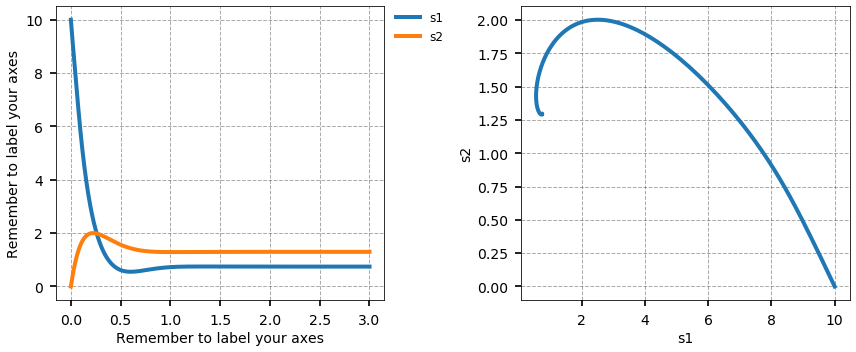

In [8]:
def v1(s2, K, k1, n):
    return k1 / (1 + (s2 / K) ** n)


pars = {
    "k1": 20,
    "k2": 5,
    "k3": 5,
    "k4": 5,
    "k5": 2,
    "K": 1,
    "n": 4,
}

m = Model(pars)
m.add_compounds(["s1", "s2"])
m.add_rate(rate_name="v1", function=v1, substrates=["s2"], parameters=["K", "k1", "n"])
m.add_rate(rate_name="v2", function=rf.constant, parameters=["k2"])
m.add_rate(rate_name="v3", function=rf.mass_action_1, substrates=["s1"], parameters=["k3"])
m.add_rate(rate_name="v4", function=rf.mass_action_1, substrates=["s2"], parameters=["k4"])
m.add_rate(rate_name="v5", function=rf.mass_action_1, substrates=["s1"], parameters=["k5"])

m.add_stoichiometries_by_compounds(
    {"s1": {"v1": 1, "v3": -1, "v5": -1}, "s2": {"v2": 1, "v5": 1, "v4": -1},}
)

s = Simulator(m)
s.initialise([10, 0])
t, y = s.simulate(3)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
s.plot(ax=axs[0])
s.plot_phase_plane("s1", "s2", ax=axs[1])
fig.tight_layout()
plt.show()

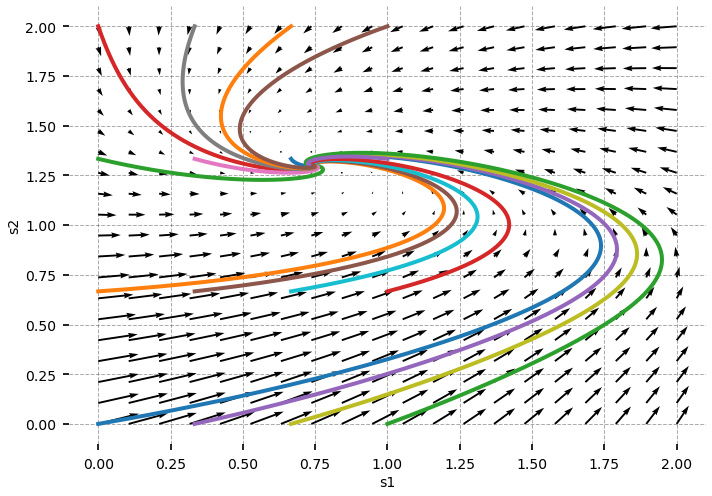

In [9]:
fig, ax = s.plot_trajectories(
    cpd1="s1", cpd2="s2", y0=[0, 0], cpd1_bounds=(0, 2), cpd2_bounds=(0, 2), n=20
)

for s1 in np.linspace(0, 1, 4):
    for s2 in np.linspace(0, 2, 4):
        s.initialise([s1, s2])
        t, y = s.simulate(1.5, 1000)
        fig, ax = s.plot_phase_plane("s1", "s2", ax=ax)
fig.tight_layout()
plt.show()

### MCA

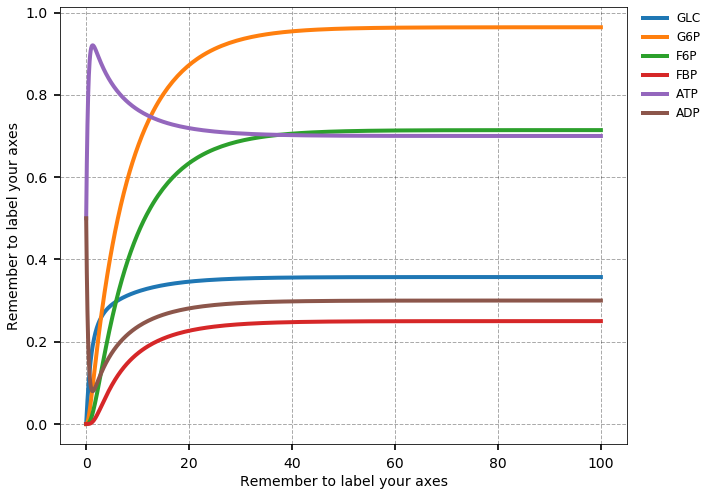

In [10]:
parameters = {
    "k1": 0.25,
    "k2": 1,
    "k3": 1,
    "k3m": 1,
    "k4": 1,
    "k5": 1,
    "k6": 1,
    "k7": 2.5,
}

# Instantiate model
m = Model(parameters)
m.add_compounds(["GLC", "G6P", "F6P", "FBP", "ATP", "ADP"])

m.add_reaction(
    rate_name="v1", function=rf.constant, stoichiometry={"GLC": 1}, parameters=["k1"],
)
m.add_reaction(
    rate_name="v2",
    function=rf.mass_action_2,
    stoichiometry={"GLC": -1, "ATP": -1, "G6P": 1, "ADP": 1},
    parameters=["k2"],
)
m.add_reaction(
    rate_name="v3",
    function=rf.reversible_mass_action_1_1,
    stoichiometry={"G6P": -1, "F6P": 1},
    parameters=["k3", "k3m"],
    reversible=True,
)
m.add_reaction(
    rate_name="v4",
    function=rf.mass_action_2,
    stoichiometry={"F6P": -1, "ATP": -1, "ADP": 1, "FBP": 1},
    parameters=["k4"],
)
m.add_reaction(
    rate_name="v5",
    function=rf.mass_action_1,
    stoichiometry={"FBP": -1, "F6P": 1},
    parameters=["k5"],
)
m.add_reaction(
    rate_name="v6",
    function=rf.mass_action_1,
    stoichiometry={"FBP": -1},
    parameters=["k6"],
)
m.add_reaction(
    rate_name="v7",
    function=rf.mass_action_1,
    stoichiometry={"ADP": -1, "ATP": 1},
    parameters=["k7"],
)

y0 = {
    "GLC": 0,
    "G6P": 0,
    "F6P": 0,
    "FBP": 0,
    "ATP": 0.5,
    "ADP": 0.5,
}

s = Simulator(m)
s.initialise(y0)
t, y = s.simulate(100)
fig, ax = s.plot()
plt.show()

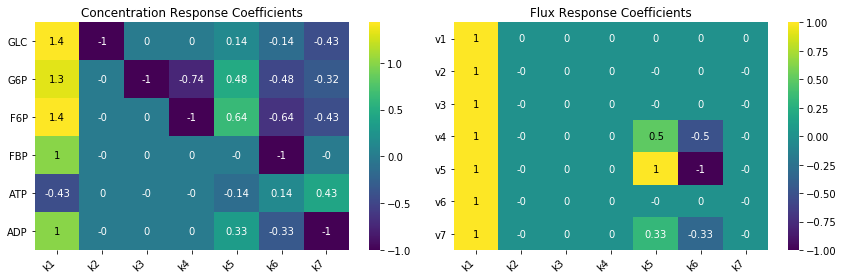

In [11]:
rates = ["v1", "v2", "v3", "v4", "v5", "v6", "v7"]
parameters = ["k1", "k2", "k3", "k4", "k5", "k6", "k7"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs = axs.ravel()

crc = mca.plot_concentration_response_coefficients(
    m,
    parameters,
    y0,
    normalized=True,
    ax=axs[0],
    rows=["GLC", "G6P", "F6P", "FBP", "ATP", "ADP"],
)
frc = mca.plot_flux_response_coefficients(m, parameters, y0, normalized=True, ax=axs[1])

fig.tight_layout()
plt.show()

### OOP and Python interaction

In [12]:
def simulate_and_plot(m):
    s = Simulator(m)
    s.initialise([0, 1])
    t, y = s.simulate(100)
    fig, ax = s.plot_selection(["x"])
    ax_ins = ax.inset_axes([0.77, 0.7, 0.2, 0.2 * 8 / 6])
    ax_ins.set_aspect("equal")
    fig, ax_ins = s.plot_phase_plane("x", "y", ax=ax_ins)
    ax_ins.xaxis.set_visible(False)
    ax_ins.yaxis.set_visible(False)

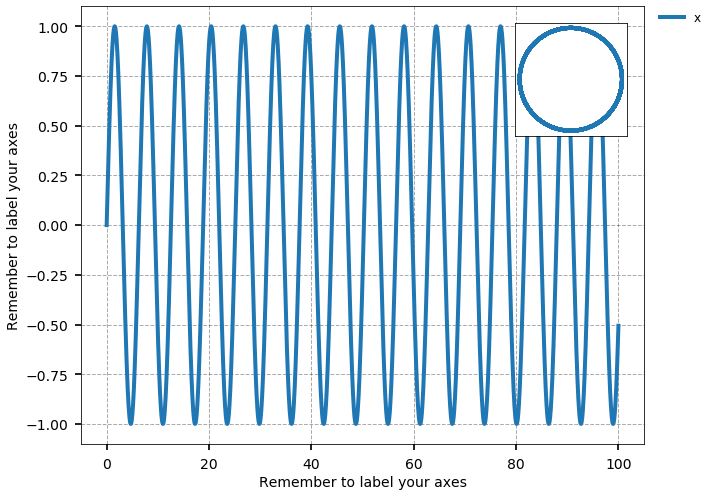

In [13]:
parameters = {"m": 1, "k": 1}
m = Model(parameters)
m.add_compounds(["x", "y"])
m.add_reaction(
    rate_name="dxdt", function=lambda y: y, stoichiometry={"x": 1}, modifiers=["y"],
)
m.add_reaction(
    rate_name="dydt",
    function=lambda x, k, m: -k / m * x,
    stoichiometry={"y": 1},
    modifiers=["x"],
    parameters=["k", "m"],
)
simulate_and_plot(m)

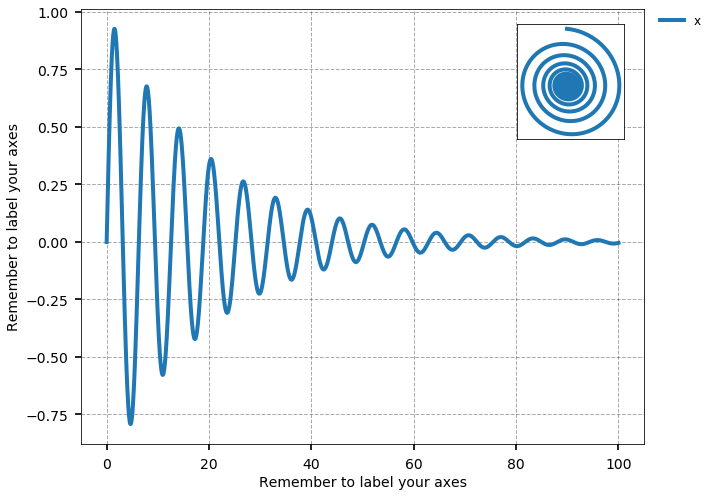

In [14]:
# Dampened harmonic oscillator

with m:
    m.remove_reaction("dydt")
    m.add_parameter("g", 0.1)
    m.add_reaction(
        rate_name="dydt",
        function=lambda x, y, k, g, m: (-k * x - g * y) / m,
        stoichiometry={"y": 1},
        modifiers=["x", "y"],
        parameters=["k", "g", "m"],
    )
    simulate_and_plot(m)

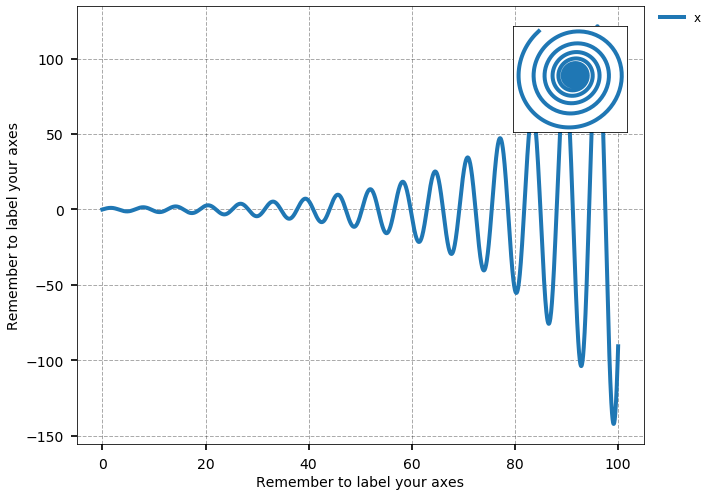

In [15]:
# Accelerated harmonic oscillator


with m:
    m.remove_reaction("dydt")
    m.add_parameter("g", 0.1)
    m.add_reaction(
        rate_name="dydt",
        function=lambda x, y, k, g, m: (-k * x + g * y) / m,
        stoichiometry={"y": 1},
        modifiers=["x", "y"],
        parameters=["k", "g", "m"],
    )
    simulate_and_plot(m)

### Derived parameters

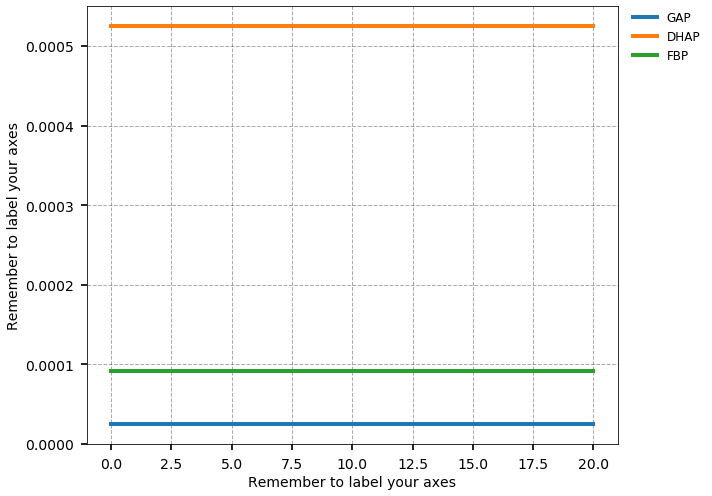

In [16]:
p = {
    "kf_TPI": 1.0,
    "Keq_TPI": 21.0,
    "kf_Ald": 2000.0,
    "Keq_Ald": 7000.0,
}

m = Model(p)
m.add_derived_parameter(
    parameter_name="kr_TPI",
    function=lambda x, y: x / y,
    parameters=["kf_TPI", "Keq_TPI"],
)
m.add_derived_parameter(
    parameter_name="kr_Ald",
    function=lambda x, y: x / y,
    parameters=["kf_Ald", "Keq_Ald"],
)

m.add_compounds(["GAP", "DHAP", "FBP"])
m.add_reaction(
    rate_name="TPIf",
    function=rf.mass_action_1,
    stoichiometry={"GAP": -1, "DHAP": 1},
    parameters=["kf_TPI"],
    reversible=False,
)
m.add_reaction(
    rate_name="TPIr",
    function=rf.mass_action_1,
    stoichiometry={"DHAP": -1, "GAP": 1},
    parameters=["kr_TPI"],
    reversible=False,
)
m.add_reaction(
    rate_name="ALDf",
    function=rf.mass_action_2,
    stoichiometry={"DHAP": -1, "GAP": -1, "FBP": 1},
    parameters=["kf_Ald"],
    reversible=False,
)
m.add_reaction(
    rate_name="ALDr",
    function=rf.mass_action_1,
    stoichiometry={"FBP": -1, "DHAP": 1, "GAP": 1,},
    parameters=["kr_Ald"],
    reversible=False,
)

# set initial concentrations
GAP0 = 2.50e-5
DHAP0 = GAP0 * m.parameters["Keq_TPI"]
FBP0 = GAP0 * DHAP0 * m.parameters["Keq_Ald"]
base_y0 = {"GAP": GAP0, "DHAP": DHAP0, "FBP": FBP0}

s = Simulator(m)
s.initialise(base_y0)
t, y = s.simulate(20)
s.plot()
plt.show()

y_ss = base_y0
v_ss = {k: v[0] for k, v in m.get_fluxes_dict(y_ss).items()}

## Isotope-labeled models

### Linear Label Model

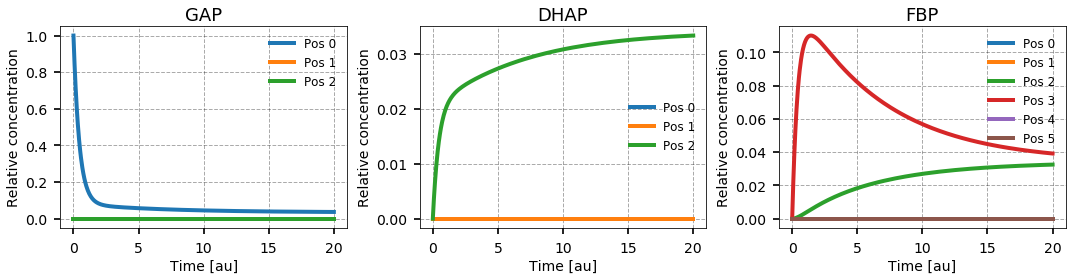

In [17]:
llm = m.to_linear_labelmodel(
    labelcompounds={"GAP": 3, "DHAP": 3, "FBP": 6},
    labelmaps={
        "TPIf": [2, 1, 0],
        "TPIr": [2, 1, 0],
        "ALDf": [0, 1, 2, 3, 4, 5],
        "ALDr": [0, 1, 2, 3, 4, 5],
    },
)

y0 = llm.generate_y0(initial_labels={"GAP": 0})

lls = Simulator(llm)
lls.initialise(y0, y_ss, v_ss)
t, y = lls.simulate(20)
fig, ax = lls.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"], sharey=False, xlabels="Time [au]"
)
plt.show()

### Label Model

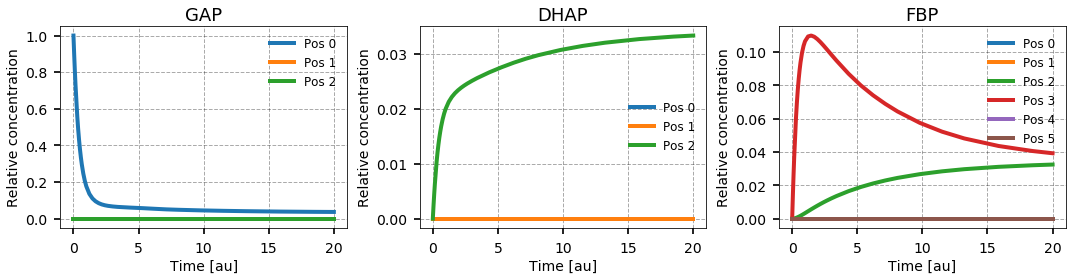

In [18]:
lm = m.to_labelmodel(
    {"GAP": 3, "DHAP": 3, "FBP": 6},
    {
        "TPIf": [2, 1, 0],
        "TPIr": [2, 1, 0],
        "ALDf": [0, 1, 2, 3, 4, 5],
        "ALDr": [0, 1, 2, 3, 4, 5],
    },
)


y0 = lm.generate_y0(base_y0, label_positions={"GAP": 0})
ls = Simulator(lm)
ls.initialise(y0)
t, y = ls.simulate(20)
fig, ax = ls.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"], sharey=False, relative=True, xlabels="Time [au]"
)
plt.show()

### Label scopes

In [19]:
lm.get_label_scope({"GAP": 0})

{0: {'DHAP__001', 'FBP__000100'}, 1: {'FBP__001000', 'FBP__001100'}}